In [ ]:
#librerias

In [2]:
import astropy
import numpy as np
import scipy
import numpy
import pyspeckit
import zipfile
import os
import re
import matplotlib.pyplot as plt
from astropy.table import QTable,Table,Column
from astropy.io import ascii
from sklearn.metrics import auc
from openpyxl import load_workbook
import xlrd

In [3]:
#parte 2: funciones

In [4]:
def Filterdat(lista): #filtrar datos de directorios por ".dat"
    return [name for name in lista if re.search(r'dat', name)]

def colxfil(mat): #en una tabla, o matriz, cambiar filas por columnas
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2

#def norm(lista): #normalizacion de datos por preprocessing
#    return preprocessing.normalize(lista)

def norm(lista): #normalización de datos por maximos y minimos
    a=[]
    for f in lista:
        a.append((f-min(lista))/(max(lista)-min(lista)))
    return a

def unique(lista):
    uni=[]
    for l in lista:
        if l not in uni:
            uni.append(l)
    return uni

def recta2(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return (m*evaluar)+c 

def MtoL(value):
    M_sun=4.83
    L_sun=3.8*(10**33)
    return L_sun*10**((value-M_sun)/(-2.5))

def convol(espectra, filtro): #entrada de variables
    
    #parte 1: separar datos y limites
    espec=[]
    fl=[]
    espec_wl=[]
    fl_wl=[]
    coords1=[]
    coords2=[]
    for pair in espectra: #guardado de datos para crear tabala general en base a los "S" y "F"
        espec.append((float(pair[0]),float(pair[1]),'S'))
        coords1.append((float(pair[0]),float(pair[1])))
        espec_wl.append(float(pair[0]))
    for pair in filtro:
        fl.append((float(pair[0]),float(pair[1]),'F'))
        coords2.append((float(pair[0]),float(pair[1])))
        fl_wl.append(float(pair[0])) #limites 
    
    
    minimum=min(fl_wl) #limite minimo
    maximum=max(fl_wl) #limite maximo
    
    wl=(sorted(espec+fl)) #conjunto ordenado en funcion de la longitud de onda
    no_existe_en_spec=[value for value in fl_wl if  value not in espec_wl]
    no_existe_en_fil=[value for value in espec_wl if  value not in fl_wl]
    
    #parte 2: generar tabla final con datos
    final_table=Table() 
    final_table['Wavelength']=([w[0] for w in wl]) #tabla general
    final_table['Spectra']=[None for i in wl]
    final_table['Filter']=[None for i in wl]
    
    for wave,tri in zip(final_table['Wavelength'],wl):
        indice_wl=list(final_table['Wavelength']).index(wave) #fila
        if tri[2]=='S': #ordenar segun indice "S"pectra
            final_table['Spectra'][indice_wl]=tri[1]
        if tri[2]=='F': #ordenar segun indice "F"ilter
            final_table['Filter'][indice_wl]=tri[1]
    
    #parte 3: quitar vacios repetidos                                              
    general=[]
    vacios=[]
    for tri in final_table:
        general.append(tri)
        if tri['Spectra']==None and tri['Filter']==None:
            vacios.append(tri)
    for tri in vacios:
        general.remove(tri)
     
       
    #parte 4: tabla reducida
    tabla_redu=Table()
    WL=[]
    SP=[]                                              
    FL=[]
    for tri in general:
        WL.append(tri['Wavelength'])
        SP.append(tri['Spectra'])
        FL.append(tri['Filter'])
    
    tabla_redu['Wavelength']=WL
    tabla_redu['Spectra']=SP                                            
    tabla_redu['Filter']=FL 
    
    
    #parte 5: rellenar
    
    #spectra
    indices1=[coords1.index(value) for value in coords1]
    
    valores=[]
    lambda_A=[]
    for index in indices1[:len(indices1)-1]:
        puntos=[coords1[index],coords1[index+1]]
        
        for value in no_existe_en_spec:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_A.append(value)
                valores.append([value,aux])
    
    SP_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_A]
    for pair,ind in zip(valores,SP_ind):
        if tabla_redu['Spectra'][ind]==None:
            tabla_redu['Spectra'][ind]=pair[1]
    
    
    
    
   #filtro
    indices2=[coords2.index(value) for value in coords2]
    
    valores=[]
    lambda_B=[]
    for index in indices2[:len(indices2)-1]:
        puntos=[coords2[index],coords2[index+1]]
        
        for value in no_existe_en_fil:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_B.append(value)
                valores.append([value,aux])
    
    FL_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_B]
    for pair,ind in zip(valores,FL_ind):
        if tabla_redu['Filter'][ind]==None:
            tabla_redu['Filter'][ind]=pair[1]

    tabla_redu=tabla_redu[tabla_redu['Wavelength']>=minimum]
    tabla_redu=tabla_redu[tabla_redu['Wavelength']<=maximum]

    
    Tabla_salida=Table()
    Tabla_salida['WL']=tabla_redu['Wavelength']
    Tabla_salida['Spectra']=tabla_redu['Spectra']*tabla_redu['Filter']*tabla_redu['Wavelength']
    
    superior=auc(Tabla_salida['WL'],Tabla_salida['Spectra'])
    inferior=auc(tabla_redu['Wavelength'],(tabla_redu['Filter']*tabla_redu['Wavelength']))
    
    Luminosidad=(superior/inferior)
    return Luminosidad
'''
    #parte 6: tabla de minimos
    espectro_final=[]
    for tri in tabla_redu:
        if type(tri['Spectra'])==type(None):
            espectro_final.append(tri['Filter'])
        if type(tri['Filter'])==type(None):
            espectra_final.append(tri['Spectra'])
        if type(tri['Spectra'])!=type(None) or type(tri['Filter'])==type(None):
            espectro_final.append(min([tri['Spectra'],tri['Filter']]))
    
    #return tabla_redu['Wavelength']

    Out=Table()
    Out['Wavelength']=tabla_redu['Wavelength']
    Out['Spectra']=espectro_final

    return [Out,auc(Out['Wavelength'],Out['Spectra'])]'''

"\n    #parte 6: tabla de minimos\n    espectro_final=[]\n    for tri in tabla_redu:\n        if type(tri['Spectra'])==type(None):\n            espectro_final.append(tri['Filter'])\n        if type(tri['Filter'])==type(None):\n            espectra_final.append(tri['Spectra'])\n        if type(tri['Spectra'])!=type(None) or type(tri['Filter'])==type(None):\n            espectro_final.append(min([tri['Spectra'],tri['Filter']]))\n    \n    #return tabla_redu['Wavelength']\n\n    Out=Table()\n    Out['Wavelength']=tabla_redu['Wavelength']\n    Out['Spectra']=espectro_final\n\n    return [Out,auc(Out['Wavelength'],Out['Spectra'])]"

In [5]:
#espectros

In [9]:
datos=os.listdir('SC2')
datos=sorted(datos[1:len(datos)])


search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'SC2/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

print(subdatos)
ind=[subdatos.index(i)+65 for i in subdatos]
ltr=[chr(number) for number in ind]
names=[f'{search2}{letra}' for letra in ltr]


search3=''
while search3 not in ltr:
    print('Options:')
    for value,lt in zip(names,ltr):
        print(f'for {value}, mark {lt}')
    try:
        search3=str(input('Which file would you want to open? >')).upper()
    except(ValueError):
        pass
    
ind2=ltr.index(search3)
topen=f'SC2/{search2}/{subdatos[ind2]}'

The options are: 
fig1
fig13
fig15
fig2
fig25
fig27
fig7
fig9
File name: >fig1
['fig1a.dat.txt', 'fig1b.dat.txt', 'fig1c.dat.txt', 'fig1d.dat.txt', 'fig1e.dat.txt']
Options:
for fig1A, mark A
for fig1B, mark B
for fig1C, mark C
for fig1D, mark D
for fig1E, mark E
Which file would you want to open? >a


In [10]:
alpha=[]
print(topen)
with open(topen,'r') as datos:
    line=datos.readlines()
    for linea in line:
        alpha.append(linea.split())
        
columns=(alpha[2][1:])
ages=columns[1:]

totaldatos=alpha[3:]
test001=colxfil(totaldatos)

wavelength=[(aux[0]) for aux in totaldatos]

por_longitud=[(aux[1:]) for aux in totaldatos] #usar este
por_edad=colxfil(por_longitud)

SC2/fig1/fig1a.dat.txt


In [11]:
FloatNorm_por_edad=[]
for i in por_edad:
    FloatNorm_por_edad.append(([10**float(l) for l in i]))
#[len(i) for i in FloatNorm_por_edad]
len(FloatNorm_por_edad)

36

In [12]:
#tabla sin cambios
Tabla_datos=Table()
Tabla_datos['WL']=[(float(w)) for w in wavelength]
NE=([(i) for i in FloatNorm_por_edad])
for edad,name in zip(NE,ages):
    Tabla_datos[f'{name}']=edad
Tabla_datos

WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
91.0,5.837272932134056e+21,1.58441884777183e+18,31505762874372.52,9.649170935126327e+37,5.053706312080134e+37,1.1791254141875021e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
94.0,1.7698236734542554e+22,5.781626070041748e+18,163305194789433.12,1.1498733270192298e+38,5.853963361969231e+37,1.3685794042113347e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
96.0,5.114109233610705e+22,1.9999079186841993e+19,796636131530359.4,1.3014874960156381e+38,6.5023448731385145e+37,1.5218785641919605e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
98.0,9.579878477300709e+22,4.1559469957349196e+19,2008676506101905.2,1.4522453681696422e+38,7.140851472862781e+37,1.6728230344426805e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
100.0,1.9579878836951562e+23,9.592239196648061e+19,5857738768542005.0,1.5651285009303196e+38,7.583330779213202e+37,1.7775015986585798e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
102.0,4.7058708062911174e+23,2.6749150854504425e+20,2.1649606146574732e+16,1.646645076720635e+38,7.8800686315699e+37,1.847736338735044e+38,0.00020873246409311812,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400000.0,2.501900304647209e+35,1.994435519292416e+35,9.906266334291898e+34,4.81315668827798e+34,2.0197145772534026e+34,1.5656331200786341e+34,2.0258160145013715e+33,1.029484945101395e+33,5.9919751005621105e+32,3.603877330866343e+32,2.5405046841870915e+32,1.6962114870357438e+32,1.3493045970659892e+32,9.613687478754846e+31,8.096549959081958e+31,5.900516103988252e+31,5.340599367676909e+31,4.791042242073688e+31,3.873557436493677e+31,3.576185187431009e+31,1.4527470425811789e+31,8.61945883716895e+30,6.162259740962975e+30,5.229738817903111e+30,4.5560659294874466e+30,4.1613093283113163e+30,3.6488835200254484e+30,3.152898573291915e+30,1.8965312361846144e+30,1.6908691481211236e+30,1.4603266134485764e+30,1.2058686372798525e+30,9.918591406618258e+29,8.569391807817362e+29,9.359011911145897e+29,8.074395161524759e+29
600000.0,2.189172580784075e+35,1.7450987201181708e+35,8.667822315587182e+34,4.211240070632885e+34,1.7669326668366646e+34,1.368264313435411e+34,1.7371607171842677e+33,8.26894303362769e+32,4.6677759280693604e+32,2.7025267415611775e+32,1.8886000637072752e+32,1.1746811507440494e+32,8.91764131109453e+31,5.86624233825085e+31,4.97725624290961e+31,3.216918068338416e+31,2.8355022745537983e+31,2.4539742427471626e+31,1.739562352015748e+31,1.5549627868035885e+31,4.1984598077511173e+30,1.9607851087854203e+30,1.274970099943712e+

In [13]:
Tablas_espectros_por_edad=[Table() for edad in range(len(columns[1:]))]
c=0

for table,name in zip(Tablas_espectros_por_edad,columns[1:]):
    if name!='[A]':
        #Tabla_datos=Tabla_datos[Tabla_datos['WL']<20000]
        table['WL']=Tabla_datos['WL']
        table[f'{name}']=Tabla_datos[name]

Tablas_espectros_por_edad

[<Table length=1221>
     WL             1Myr         
  float64         float64        
 --------- ----------------------
      91.0  5.837272932134056e+21
      94.0 1.7698236734542554e+22
      96.0  5.114109233610705e+22
      98.0  9.579878477300709e+22
     100.0 1.9579878836951562e+23
     102.0 4.7058708062911174e+23
       ...                    ...
  400000.0  2.501900304647209e+35
  600000.0  2.189172580784075e+35
  800000.0  1.876419769846854e+35
 1000000.0 1.5636876279567622e+35
 1200000.0 1.2509501398340607e+35
 1400000.0   9.38209875556281e+34
 1600000.0  6.254750636722585e+34,
 <Table length=1221>
     WL             2Myr         
  float64         float64        
 --------- ----------------------
      91.0   1.58441884777183e+18
      94.0  5.781626070041748e+18
      96.0 1.9999079186841993e+19
      98.0 4.1559469957349196e+19
     100.0  9.592239196648061e+19
     102.0 2.6749150854504425e+20
       ...                    ...
  400000.0  1.994435519292416e+35
  600

In [14]:
tabula=Table() #filtro V
TSP=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_V-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSP['[A]']=(alpha)
TSP['Tr']=[float(b) for b in bet]
tabula['[A]']=((alpha))
tabula['Tr']=(beta)
print(len(tabula))
tabula=tabula[tabula['Tr']>10**-18]
print(max(tabula['Tr']))
len(tabula)

1801
94.12832642


1093

In [15]:
tabulaB=Table() #filtro B
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_B-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

tabulaB['[A]']=((alpha))
tabulaB['Tr']=(beta)
print(len(tabulaB))
tabulaB=tabulaB[tabulaB['Tr']>10**-18]
print(max(tabulaB['Tr']))
len(tabulaB)

1801
79.69796753


1078

In [16]:
tabulaI=Table() #filtro I

alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_I-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))


tabulaI['[A]']=((alpha))
tabulaI['Tr']=(beta)
print(len(tabulaI))
tabulaI=tabulaI[tabulaI['Tr']>10**-18]
print(max(tabulaI['Tr']))
len(tabulaI)

1801
96.20352936


1153

In [17]:
tabulaR=Table() #filtro R

alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_R-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))


tabulaR['[A]']=((alpha))
tabulaR['Tr']=(beta)
print(len(tabulaR))
tabulaR=tabulaR[tabulaR['Tr']>10**-18]
print(max(tabulaR['Tr']))
len(tabulaR)

1800
81.95018005


1290

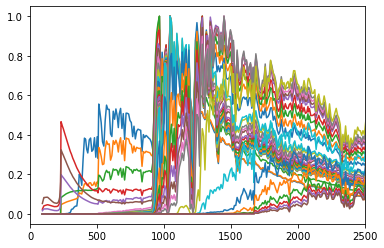

In [23]:
for esp,name in zip(Tablas_espectros_por_edad,columns[1:]):
    plt.plot((esp['WL']),norm(esp[name]))
#plt.plot(tabula['[A]'],tabula['Tr'])
plt.xlim(0,2500)
#plt.ylim(10**-15,2)
plt.show()

In [322]:
convolu=[] #convolucion del filtro V, convolu guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabula)
    print(f'Edad {Ename} : {convolucion}')
    convolu.append([Ename,convolucion])
    

Edad 1Myr : 5.964564552638302e+37
Edad 2Myr : 6.519240942099743e+37
Edad 3Myr : 6.029155385734047e+37
Edad 4Myr : 6.53099804612041e+37
Edad 5Myr : 5.09740647460492e+37
Edad 6Myr : 6.00220396856068e+37
Edad 7Myr : 4.598295807574706e+37
Edad 8Myr : 2.4997979260634283e+37
Edad 9Myr : 2.403375616789481e+37
Edad 10Myr : 2.28038041128134e+37
Edad 11Myr : 2.0307993459890528e+37
Edad 12Myr : 1.9004156551149258e+37
Edad 13Myr : 1.7735137042186264e+37
Edad 14Myr : 1.6505655321042538e+37
Edad 15Myr : 1.5305724264871479e+37
Edad 16Myr : 1.4594497946805883e+37
Edad 17Myr : 1.4044495868075155e+37
Edad 18Myr : 1.3573490629404229e+37
Edad 19Myr : 1.293051459057435e+37
Edad 20Myr : 1.2492285886149125e+37
Edad 30Myr : 1.006907186914944e+37
Edad 40Myr : 8.294779423391303e+36
Edad 50Myr : 7.479132262066171e+36
Edad 60Myr : 6.8962382028196e+36
Edad 70Myr : 6.338870150129113e+36
Edad 80Myr : 5.776427535837815e+36
Edad 90Myr : 5.422766948580161e+36
Edad 100Myr : 5.0213965898369626e+36
Edad 200Myr : 3.3057942

In [340]:
l=[]
edad=[]
for value in convolu:
    #l.append()
    l.append(-4.83-2.5*np.log10(value[1]/(3.8*(10**33))))
    edad.append(float((value[0].split('M'))[0])*(10**6))
l

[-15.319487866407941,
 -15.41603358910365,
 -15.331182200497063,
 -15.417989893040064,
 -15.148914174065705,
 -15.326317882595943,
 -15.037033273260223,
 -14.375303266995504,
 -14.332595135375016,
 -14.275559262734799,
 -14.149708545632373,
 -14.077662506866652,
 -14.00262738016428,
 -13.924622937767365,
 -13.842675721402255,
 -13.791013907901652,
 -13.74930639513348,
 -13.71226987708147,
 -13.659580530133027,
 -13.62214579472696,
 -13.388014610193649,
 -13.177553112605553,
 -13.065169042003797,
 -12.977071643538867,
 -12.885570647132276,
 -12.784689332389497,
 -12.716093359432058,
 -12.632602316711589,
 -12.17873056937813,
 -11.90844732238373,
 -11.670506098091188,
 -11.475171363727897,
 -11.29298277641308,
 -11.153245176155806,
 -11.021930532578523,
 -10.817815199477732]

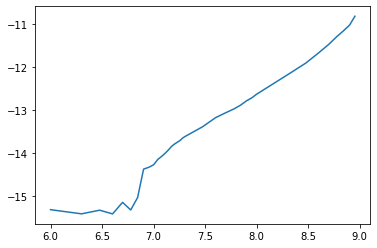

In [337]:
plt.plot(np.log10(edad),l)
#plt.xlim(6,9)

plt.show()

In [107]:
datos=os.listdir('Magnitud')
datos=sorted(datos[1:len(datos)])


search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'Magnitud/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

print(subdatos)
ind=[subdatos.index(i)+65 for i in subdatos]
ltr=[chr(number) for number in ind]
names=[f'{search2}{letra}' for letra in ltr]


search3=''
while search3 not in ltr:
    print('Options:')
    for value,lt in zip(names,ltr):
        print(f'for {value}, mark {lt}')
    try:
        search3=str(input('Which file would you want to open? >')).upper()
    except(ValueError):
        pass
    
ind2=ltr.index(search3)
topen=f'Magnitud/{search2}/{subdatos[ind2]}'

The options are: 
V
File name: >V
['mv_inst_a.dat.txt', 'mv_inst_b.dat.txt', 'mv_inst_c.dat.txt', 'mv_inst_d.dat.txt', 'mv_inst_e.dat.txt']
Options:
for VA, mark A
for VB, mark B
for VC, mark C
for VD, mark D
for VE, mark E
Which file would you want to open? >a


In [195]:
Magnitudes=ascii.read(topen) #col1:time[Yr], col2:2.35,100
Magnitudes['col1']=np.log10(Magnitudes['col1'])
Magnitudes

col1,col2,col3,col4
float64,float64,float64,float64
4.0,-15.173,-13.308,-14.262
5.041392685158225,-15.183,-13.312,-14.268
5.3222192947339195,-15.201,-13.319,-14.279
5.491361693834273,-15.212,-13.325,-14.289
5.6127838567197355,-15.22,-13.33,-14.299
5.707570176097937,-15.206,-13.329,-14.297
5.785329835010767,-15.225,-13.336,-14.298
5.8512583487190755,-15.247,-13.345,-14.309
5.9084850188786495,-15.261,-13.35,-14.32


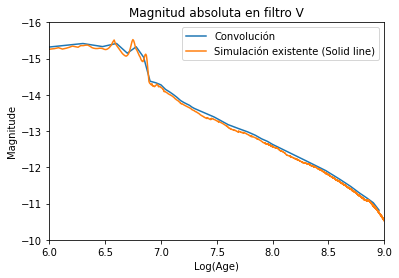

In [356]:
plt.plot(np.log10(edad),l)
plt.plot(Magnitudes['col1'],Magnitudes['col2'])
plt.legend(['Convolución','Simulación existente (Solid line)'])
plt.ylabel('Magnitude')
plt.xlabel('Log(Age)')
plt.title('Magnitud absoluta en filtro V')
plt.xlim(6,9)
plt.ylim(-10,-16)
plt.savefig('Abs_mag_v')
plt.show()